In [6]:
# import libraries
import numpy as np
import pandas as pd
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

STOP_WORDS = ['yeah', 'oh', 'ooh']

In [7]:
"""
import spotify csv files with customised settings
"""
def import_csv(file_path: str):
  return pd.read_csv(file_path, header=0, index_col=0)

# check if CleanData folder exist
import_folder_path = os.path.join("..", "datasets", "CleanData")
if not os.path.exists(import_folder_path):
  raise Exception("Dataset CleanData not found! Run notebooks/preprocessing.ipynb to get the datasets") 

# export folder path
image_output_folder_path = os.path.join("..", "output")
if not os.path.exists(image_output_folder_path):
  os.makedirs(image_output_folder_path)

# image for wordcloud
image_input_folder_path = os.path.join("..", "image")
if not os.path.exists(image_input_folder_path):
  print("Warning, image folder not found")
  image_input_folder_path = None


In [8]:
"""
combine songs by top artists
"""
def get_top_artists(df: pd.DataFrame):
  all_songs = df.to_dict('records')
  top_artist = {}

  # get artists and their songs
  for song in all_songs:
    uid: str = song['uid']
    # get the first artist
    artists: str = song['artist']
    artist = artists.split(',')[0].strip()
    """
      get_song: {
        artist: str
        streams: number
        uid_list: str[list]
        lyrics_list: str[list]
      }
    """
    get_song = top_artist.get(artist)

    # if None, means artist have yet to be added to list
    if (get_song == None):
      top_artist[artist] = {
        'artist': artist,
        'streams': song['streams'],
        'uid_list': [uid],
        'lyrics_list': [song['cleaned_lyrics']],
      }

    else:
      streams = get_song['streams'] + song['streams']
      get_song['streams'] = streams

      # if uid is not found, add to uid_list
      # to prevent multiple same songs from showing up when calcualating later
      uid_list: list[str] = get_song['uid_list']
      if uid not in uid_list:
        lyrics: str = song['cleaned_lyrics']
        lyrics_list: list[str] = get_song['lyrics_list']

        lyrics_list.append(lyrics)
        uid_list.append(uid)
        get_song['uid_list'] = uid_list
        get_song['lyrics_list'] = lyrics_list

  # convert dict to array
  # top_artist_list = [ artist.pop('uid_list', None) for artist  in list(top_artist.values())]
  top_artist_list = []
  for artist in list(top_artist.values()):
    artist.pop('uid_list', None)
    top_artist_list.append(artist)

  # sort array
  sorted_list = sorted(top_artist_list, key=lambda d: d['streams'], reverse=True)

  return sorted_list


"""
transfrom 0 to 255
"""
def transform_format(val):
  if val == 0:
    return 255
  else:
    return val


In [9]:
print("Starting WordCloud")
# Dataframes setup

# find csv files in the folder
csv_precovid_file_path = []
csv_covid_file_path = []
for f in os.listdir(import_folder_path):
  if f.startswith('2017') or f.startswith('2018') or f.startswith('2019'):
    csv_precovid_file_path.append(os.path.join(import_folder_path, f))
  else:
    csv_covid_file_path.append(os.path.join(import_folder_path, f))



# import csv from the list of csv path above to create a single dataframe
df_precovid: pd.DataFrame = pd.concat(map(import_csv, csv_precovid_file_path))
df_covid: pd.DataFrame = pd.concat(map(import_csv, csv_covid_file_path))

df_precovid.drop(columns=["stemmed_lyrics", "lemmatized_lyrics"], inplace=True)
df_covid.drop(columns=["stemmed_lyrics", "lemmatized_lyrics"], inplace=True)

precovid_combined_songs_list = get_top_artists(df_precovid)
covid_combined_songs_list = get_top_artists(df_covid)



Starting WordCloud


Starting Top 10 artists words


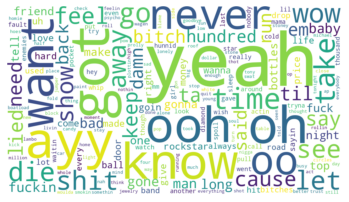

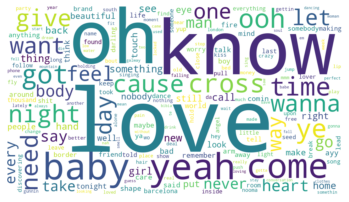

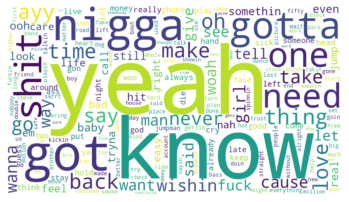

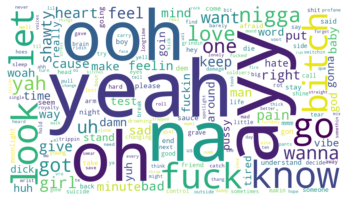

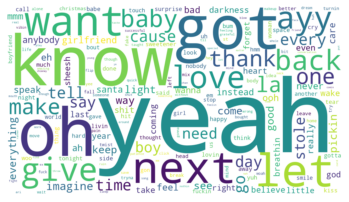

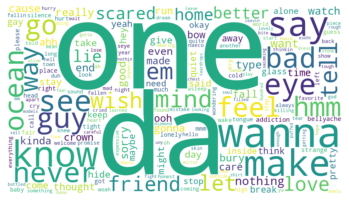

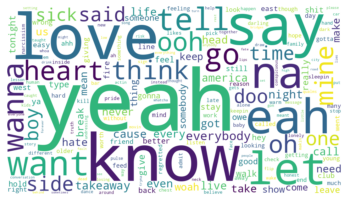

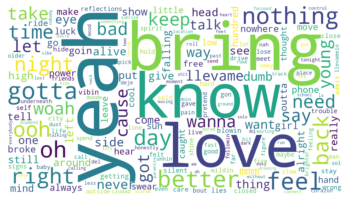

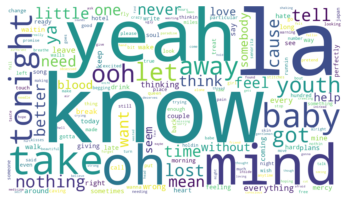

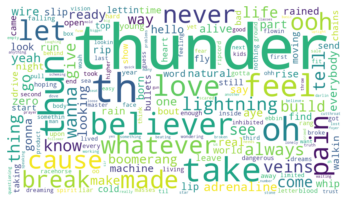

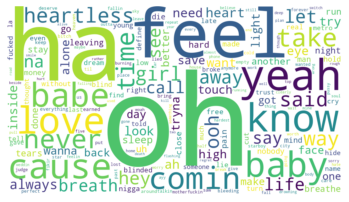

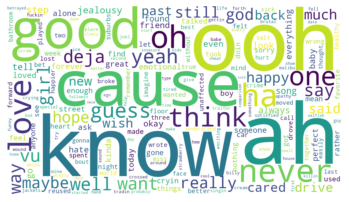

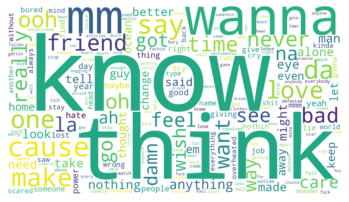

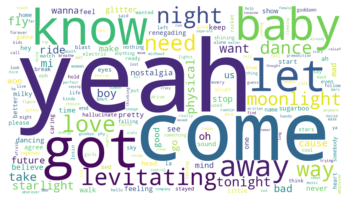

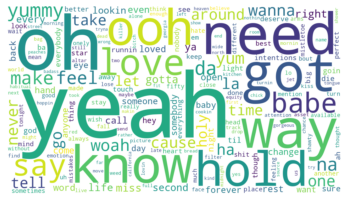

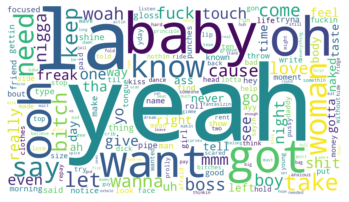

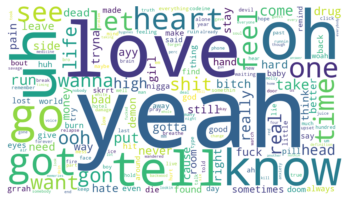

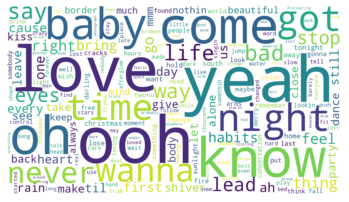

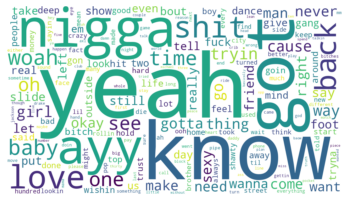

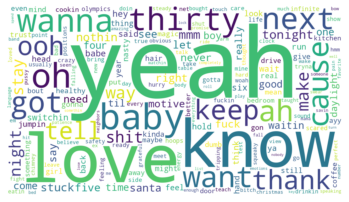

In [10]:
print("Starting Top 10 artists words")
precovid_top_10 = precovid_combined_songs_list[:10]
covid_top_10 = covid_combined_songs_list[:10]

# precovid:
# combine each artist in top10 lyrics together to get all lyrics song by that artist
for i in range(10):
  artist = precovid_combined_songs_list[i]
  combined_lyrics = " ".join(song_lyric for song_lyric in artist['lyrics_list'])
  name: str = artist['artist'].replace(" ", "_")

  wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    collocations=False
  ).generate(combined_lyrics)

  plt.figure()
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  wordcloud.to_file(os.path.join(image_output_folder_path, "precovid_" + str(i+1) + "_" + name + ".png")) 


# during covid:
# combine each artist in top10 lyrics together to get all lyrics song by that artist
for i in range(10):
  artist = covid_combined_songs_list[i]
  combined_lyrics = " ".join(song_lyric for song_lyric in artist['lyrics_list'])
  name: str = artist['artist'].replace(" ", "_")

  wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    collocations=False
  ).generate(combined_lyrics)

  plt.figure()
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  wordcloud.to_file(os.path.join(image_output_folder_path, "covid_" + str(i+1) + "_" + name + ".png")) 


Starting Combined Top 10 artists lyrics


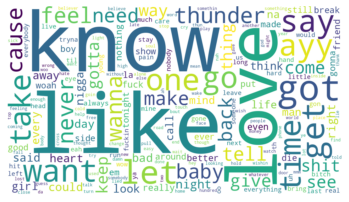

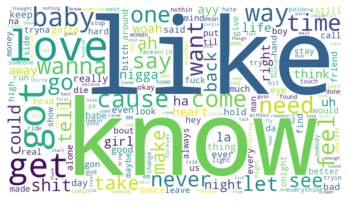

End of Program


In [11]:
print("Starting Combined Top 10 artists lyrics")

precovid_combined_lyrics = ""
covid_combined_lyrics = ""

# precovid:
# combine each artist in top10 lyrics together to get all lyrics song by that artist
for i in range(10):
  precovid_artist = precovid_combined_songs_list[i]
  covid_artist = covid_combined_songs_list[i]

  for song_lyric in precovid_artist['lyrics_list']:
    precovid_combined_lyrics: str = precovid_combined_lyrics + " " + song_lyric

  for song_lyric in covid_artist['lyrics_list']:
    covid_combined_lyrics = covid_combined_lyrics + " " + song_lyric

precovid_combined_lyrics = precovid_combined_lyrics.strip()
covid_combined_lyrics = covid_combined_lyrics.strip()

pre_wordcloud = WordCloud(
  width=1280,
  height=720,
  background_color='white',
  collocations=False,
  stopwords=STOP_WORDS
).generate(precovid_combined_lyrics)

cov_wordcloud = WordCloud(
    width=1280,
    height=720,
    background_color='white',
    collocations=False,
    stopwords=STOP_WORDS
  ).generate(covid_combined_lyrics)

pre_wordcloud.to_file(os.path.join(image_output_folder_path, "precovid_combined.png")) 
cov_wordcloud.to_file(os.path.join(image_output_folder_path, "covid_combined.png")) 

plt.figure()
plt.imshow(pre_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure()
plt.imshow(cov_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

print("End of Program")
